In [ ]:
!pip install numpy==1.20

     |████████████████████████████████| 15.3 MB 1.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 11.6 MB/s 
     |████████████████████████████████| 462 kB 36.0 MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.2 MB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 45.7 MB/s 
     |████████████████████████████████| 1.2 MB 46.6 MB/s 
     |████████████████████████████████| 352 kB 43.9 MB/s 
     |████████████████████████████████| 636 kB 45.0 MB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 237 kB 35.9 MB/s 
     |████████████████████████████████| 47.8 MB 2.1 MB/s 
     |████████████████████████████████| 99 kB 7.4 MB/s 
     |████████████████████████████████| 43 kB 698 kB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CA20172018_alignments.tsv", sep='\t')
dataset.columns =['FirstName', 'LastName', 'PID', 'PersonType', 'Organization', 'BID', 'DID', 'Speech Type', 'Alignment','Date','VID','Ayes','Naes','Abstains','MID','motionText','doPass','Text']
dataset = dataset.drop_duplicates(subset=dataset.columns.difference(['Organization', 'PersonType']))
zero_ayes = dataset["Ayes"] != 0
zero_naes = dataset["Naes"] != 0
filtered_dataset = dataset[zero_ayes & zero_naes]
options = ['Lobbyist', 'General Public'] 
filtered_dataset = filtered_dataset[filtered_dataset['PersonType'].isin(options)]
filtered_dataset = filtered_dataset.groupby(['FirstName', 'LastName','Organization' ,'PID', 'PersonType', 'BID', 'DID', 'Speech Type', 'Alignment','Date','VID','Ayes','Naes','Abstains','MID','motionText','doPass'])['Text'].apply(', '.join).reset_index()

In [ ]:

features = pd.DataFrame(columns = ['text', 'outcome'])
for index, row in filtered_dataset.iterrows():
  alignment = str(row['Alignment'])
  outcome = 0
  ayes = row['Ayes']
  naes = row['Naes']
  if (ayes > naes and ("For" in alignment or alignment == "Indeterminate" or alignment == "Neutral")) or (ayes < naes and ("Against" in alignment or alignment == "Indeterminate" or alignment == "Neutral")):
    outcome = 1
  res = {'text': row['Text'], 'outcome': outcome}
  features = features.append(res, ignore_index = True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features['text'],features['outcome'], stratify=features['outcome'])
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess_model(text_input)
outputs = bert_encoder(preprocessed_text)
print(outputs)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

{'encoder_outputs': [<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_5')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_5')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_5')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_5')>], 'default': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer_5')>, 'pooled_output': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer_5')>, 'sequence_output': <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_5')>}


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = model.fit(X_train, y_train, epochs=10, batch_size = 32)

Epoch 1/10
307/307 [==============================] - 90s 280ms/step - loss: 0.4916 - accuracy: 0.7594 - precision_2: 0.7825 - recall_2: 0.9218
Epoch 2/10
307/307 [==============================] - 85s 278ms/step - loss: 0.4340 - accuracy: 0.7986 - precision_2: 0.8264 - recall_2: 0.9115
Epoch 3/10
307/307 [==============================] - 86s 280ms/step - loss: 0.4202 - accuracy: 0.8059 - precision_2: 0.8348 - recall_2: 0.9102
Epoch 4/10
307/307 [==============================] - 86s 280ms/step - loss: 0.4157 - accuracy: 0.8108 - precision_2: 0.8420 - recall_2: 0.9072
Epoch 5/10
307/307 [==============================] - 86s 279ms/step - loss: 0.4081 - accuracy: 0.8156 - precision_2: 0.8437 - recall_2: 0.9126
Epoch 6/10
307/307 [==============================] - 86s 280ms/step - loss: 0.4046 - accuracy: 0.8157 - precision_2: 0.8466 - recall_2: 0.9083
Epoch 7/10
307/307 [==============================] - 86s 279ms/step - loss: 0.4013 - accuracy: 0.8196 - precision_2: 0.8505 - recall_2:

In [ ]:
y_test = np.asarray(y_test).astype('float32')
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.6f' %accuracy)
print('Precision: %.6f' %precision)
print('Recall: %.6f' %recall)

Accuracy: 0.823025
Precision: 0.878257
Recall: 0.875266


https://www.analyticsvidhya.com/blog/2021/12/text-classification-using-bert-and-tensorflow/

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

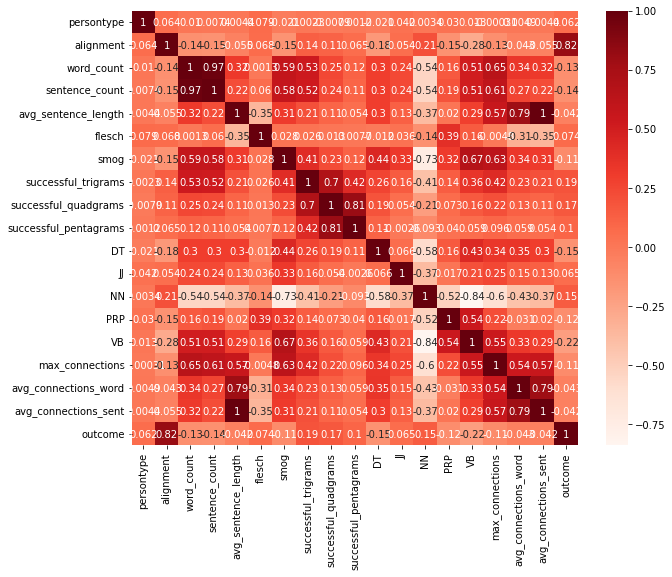

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/corr_features.csv")

# run correlation matrix and plot
f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)